In [166]:
#import libraries
import numpy as np
from scipy.stats import multivariate_normal, t
from matplotlib import pyplot as plt
from matplotlib import cm

In [6]:
#define constants
n = 5
m = 50
sigma_2 = 0.1

In [7]:
#define prior
prior_cov = np.array([[0.6,0],[0,1.2]])
prior_mean = np.array([3,3])

In [8]:
#define data
data = np.array([[0.75,0.25,5.3989], [0.25,0.75,4.6691],[0.5,0.5,5.4944],[1,0,3.7503],[0,1,2.2774]])

In [10]:
#compute prior distribution on uniform grid
nx, ny = m,m
w1 = np.linspace(0,6, nx)
w2 = np.linspace(0,6, ny)
w1v, w2v = np.meshgrid(w1, w2)

prior_samples = np.zeros((m,m))

for i in range(m):
    for j in range(m):
        prior_samples[i,j] = multivariate_normal.pdf([w1v[i,j],w2v[i,j]], prior_mean, prior_cov)

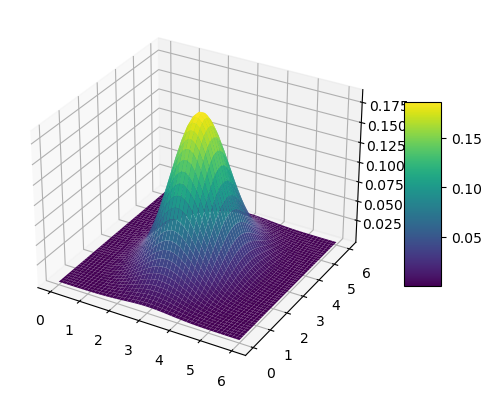

In [242]:
#plot prior distribution
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surface = ax.plot_surface(w1v,w2v,prior_samples, cmap=cm.viridis,linewidth=0, antialiased=True)
fig.colorbar(surface, shrink=0.5, aspect=5)
plt.show()

In [12]:
#function to compute likelihood function
def likelihood(x1, x2, y, w):
    sum = np.square(w[0] * x1 + w[1] * x2 + w[0] * w[1] * x1 * x2 - y)
    probability = (1 / (2 * sigma_2 * np.pi))**(n/2) * np.e**(-(1 / (2 * sigma_2)) * np.sum(sum))
    return probability

In [13]:
#store likelihood function on uniform mesh
likelihood_samples = np.zeros((m,m))

for i in range(m):
    for j in range(m):
        likelihood_samples[i,j] = likelihood(data[:,0], data[:,1], data[:,2], [w1v[i,j],w2v[i,j]])

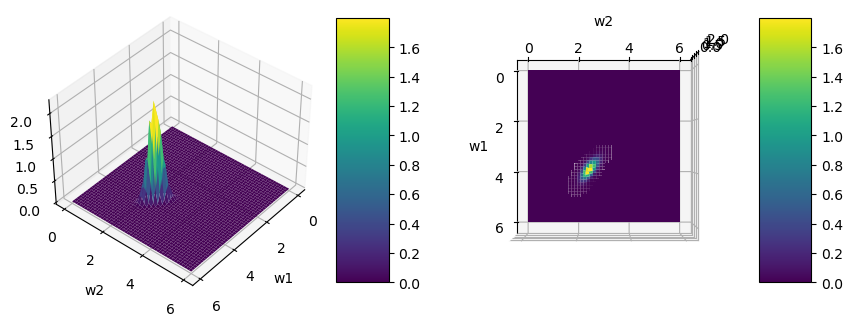

In [249]:
#plot prior distribution
#fig = plt.subplots(2)
fig, ax = plt.subplots(1,2,figsize=(10,10),subplot_kw=dict(projection='3d'))
#ax[0] = fig.add_subplot(projection='3d')
surface = ax[0].plot_surface(w1v,w2v,likelihood_samples, cmap=cm.viridis,linewidth=0, antialiased=True)
fig.colorbar(surface, shrink=0.5, aspect=5)
ax[0].view_init(40, 40)
ax[0].set_xlabel('w1')
ax[0].set_ylabel('w2')

surface = ax[1].plot_surface(w1v,w2v,likelihood_samples, cmap=cm.viridis,linewidth=0, antialiased=True)
fig.colorbar(surface, shrink=0.5, aspect=5)
ax[1].view_init(90, 0)
ax[1].set_xlabel('w1')
ax[1].set_ylabel('w2')

plt.show()

In [171]:
#monte carlo for bayesian 
nsamp = 100000
samples = np.zeros((nsamp,2))
numacc = 0 
x = np.array([3,3])

for k in range(nsamp):
    y = np.random.normal(x, 0.1)
    
    px = multivariate_normal.pdf(x, prior_mean, prior_cov) * likelihood(data[:,0], data[:,1], data[:,2], x)
    py = multivariate_normal.pdf(y, prior_mean, prior_cov) * likelihood(data[:,0], data[:,1], data[:,2], y)
    
    a = min(1, py/px)
    p = np.random.sample()
    
    if p < a:
        numacc = numacc + 1
        x = y
    else:
        x = x
    samples[k,:] = x

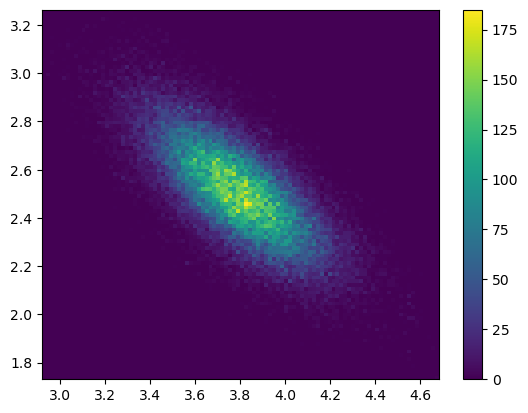

In [261]:
#2d color plot for posterior distribution
fig, ax = plt.subplots()
hh = ax.hist2d(samples[:,0], samples[:,1],bins=100)
fig.colorbar(hh[3], ax=ax)

In [297]:
multivariate_normal.pdf([3.82,2.47], prior_mean, prior_cov) * likelihood(data[:,0], data[:,1], data[:,2], [3.82,2.47])

0.21211673522026295

In [233]:
#monte carlo for bayesian, with t proposal distribution
def tmcmc(nsamp, s):
    tsamples = np.zeros((nsamp,2))
    numacc = 0 
    x = np.array([3,3])

    for k in range(nsamp):
        y = t.rvs(1, loc = x, scale=s)

        px = multivariate_normal.pdf(x, prior_mean, prior_cov) * likelihood(data[:,0], data[:,1], data[:,2], x)
        py = multivariate_normal.pdf(y, prior_mean, prior_cov) * likelihood(data[:,0], data[:,1], data[:,2], y)

        a = min(1, py/px)
        p = np.random.sample()

        if p < a:
            numacc = numacc + 1
            x = y
        else:
            x = x
        tsamples[k,:] = x
        
    rejection = 1 - (numacc / nsamp)
    return rejection, tsamples

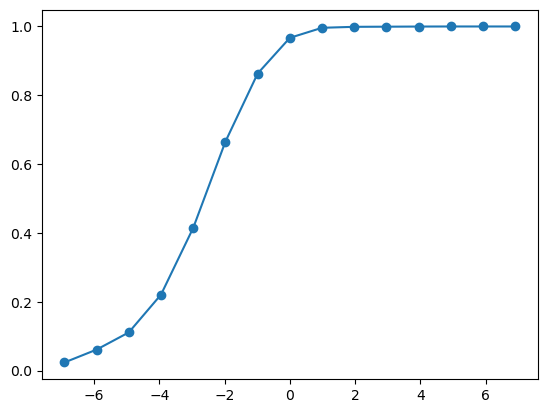

In [234]:
#test on various s values 
sindex = 15
svalues = np.logspace(-3,3,sindex)

trr = np.zeros(sindex)
nsamp = 5000

for i in range(sindex):
    trr[i], tsamples = tmcmc(nsamp, svalues[i])
plt.plot(np.log(svalues), trr)
plt.scatter(np.log(svalues), trr)

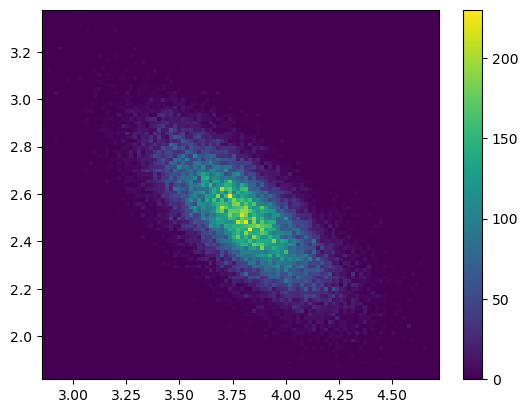

In [214]:
#compute longer tmcmc with s = 0.1
rejection, tsamples = tmcmc(100000, 0.1)
#2d color plot for posterior distribution
fig, ax = plt.subplots()
hh = ax.hist2d(tsamples[:,0], tsamples[:,1],bins=100)
fig.colorbar(hh[3], ax=ax)

In [228]:
#monte carlo for bayesian with uniform proposal distribution
def umcmc(nsamp, c):
    usamples = np.zeros((nsamp,2))
    numacc = 0 
    x = np.array([3,3])

    for k in range(nsamp):
        y = np.random.uniform(x - c, x + c, 2)

        px = multivariate_normal.pdf(x, prior_mean, prior_cov) * likelihood(data[:,0], data[:,1], data[:,2], x)
        py = multivariate_normal.pdf(y, prior_mean, prior_cov) * likelihood(data[:,0], data[:,1], data[:,2], y)

        a = min(1, py/px)
        p = np.random.sample()

        if p < a:
            numacc = numacc + 1
            x = y
        else:
            x = x
        usamples[k,:] = x
            
    rejection = 1 - (numacc / nsamp)
    return rejection, usamples

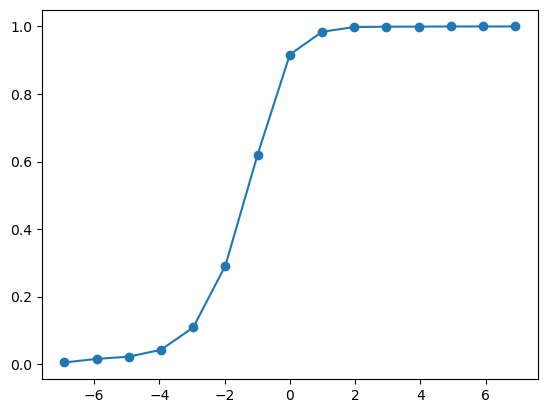

In [236]:
#test on various s values 
sindex = 15
cvalues = np.logspace(-3,3,sindex)

urr = np.zeros(sindex)
nsamp = 5000

for i in range(sindex):
    urr[i], usamples = umcmc(nsamp, cvalues[i])

plt.plot(np.log(cvalues), urr)
plt.scatter(np.log(cvalues), urr)

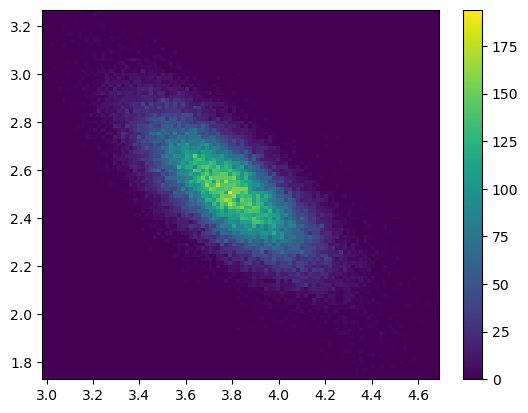

In [238]:
#compute longer tmcmc with c = 0.1
rejection, usamples = umcmc(100000, 0.1)
#2d color plot for posterior distribution
fig, ax = plt.subplots()
hh = ax.hist2d(usamples[:,0], usamples[:,1],bins=100)
fig.colorbar(hh[3], ax=ax)